In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_exgb autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data Management
import yaml
import numpy as np
import pandas as pd

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# Opti
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *
from match_forecast.formatters import *

2025-04-22 17:55:07.256 | INFO     | match_forecast.config:<module>:11 - PROJ_ROOT path is: /Users/maichoun/QRT-Challenge-2024


In [4]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
CONFIG_DIR = PROJ_ROOT / "config"
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

In [5]:
try:
    train_data = pd.read_csv(PROCESSED_DATA_DIR / "train_data.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [6]:
train_data.shape

(12303, 275)

In [7]:
train_scores = train_scores.loc[train_data.index]
train_scores_1c = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores_1c = train_scores_1c.replace(label_mapping)

train_scores_1c.head(5)

ID
0    2
1    1
2    2
3    0
4    1
dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_scores_1c, train_size=0.8, random_state=42)

In [8]:
space = {
    # number of boosting rounds
    'n_estimators':      hp.quniform('n_estimators', 100, 2000, 100),
    # maximum tree depth
    'max_depth':         hp.quniform('max_depth', 2, 20, 1),
    # step size shrinkage
    'learning_rate':     hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    # subsample ratio of the training instances
    'subsample':         hp.uniform('subsample', 0.5, 1.0),
    # subsample ratio of columns when constructing each tree
    'colsample_bytree':  hp.uniform('colsample_bytree', 0.5, 1.0),
    # minimum sum of instance weight (hessian) needed in a child
    'min_child_weight':  hp.quniform('min_child_weight', 1, 10, 1),
    # minimum loss reduction required to make a further partition
    'gamma':             hp.uniform('gamma', 0.0, 5.0),
    # L1 regularization term on weights
    'reg_alpha':         hp.uniform('reg_alpha', 0.0, 1.0),
    # L2 regularization term on weights
    'reg_lambda':        hp.uniform('reg_lambda', 0.0, 1.0),
}

In [9]:
n_folds = 3 

def objective(params):
    params['max_depth']        = int(params['max_depth'])
    params['n_estimators']     = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_fold_train, y_fold_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=3,
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_jobs=-1,
            **params
        )

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_valid)
        accuracies.append(accuracy_score(y_fold_valid, y_pred))

    mean_accuracy = np.mean(accuracies)
    return {'loss': 1 - mean_accuracy, 'status': STATUS_OK}


In [10]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100, 
            trials=trials)

print("Best hyperparameters:", best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [3:27:27<00:00, 124.47s/trial, best loss: 0.5034541694853096] 
Best hyperparameters: {'colsample_bytree': np.float64(0.858637891200674), 'gamma': np.float64(3.811536040557793), 'learning_rate': np.float64(0.004181656803679312), 'max_depth': np.float64(16.0), 'min_child_weight': np.float64(2.0), 'n_estimators': np.float64(1900.0), 'reg_alpha': np.float64(0.7581185431863467), 'reg_lambda': np.float64(0.6869494596344811), 'subsample': np.float64(0.709156755556148)}


In [ ]:
results = [
    {
        **convert_numpy(trial['result']),
        'params': {key: convert_numpy(value[0]) if value else None for key, value in trial['misc']['vals'].items()}  # Convert hyperparameters
    }
    for trial in trials.trials
]

raw_params = min(results, key=lambda x: x["loss"])['params']
formatted_params = format_xgb(raw_params)

with open(CONFIG_DIR / "xgb_params.yaml", "w") as f:
    yaml.dump(formatted_params, f)

In [12]:
with open(CONFIG_DIR / "xgb_params.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [13]:
cfg

{'colsample_bytree': 0.858637891200674,
 'gamma': 3.811536040557793,
 'learning_rate': 0.004181656803679312,
 'max_depth': 16,
 'min_child_weight': 2,
 'n_estimators': 1900,
 'reg_alpha': 0.7581185431863467,
 'reg_lambda': 0.6869494596344811,
 'subsample': 0.709156755556148}

In [15]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    **cfg
)

xgb_model.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.858637891200674, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=3.811536040557793, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.004181656803679312,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1900, n_jobs=-1, num_class=3,
              num_parallel_tree=None, ...)

In [16]:
y_pred_final = xgb_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Accuracy du modèle optimisé (test) : {final_accuracy * 100:.2f}%")

Accuracy du modèle optimisé (test) : 49.65%


In [20]:
importance_dict = dict(
    zip(
        X_train.columns,
        xgb_model.feature_importances_   
    )
)

sorted_features = sorted(
    importance_dict.items(),
    key=lambda x: x[1],
    reverse=True
)
top_features = [feat for feat, score in sorted_features[:10]]

X_reduced = train_data[top_features]

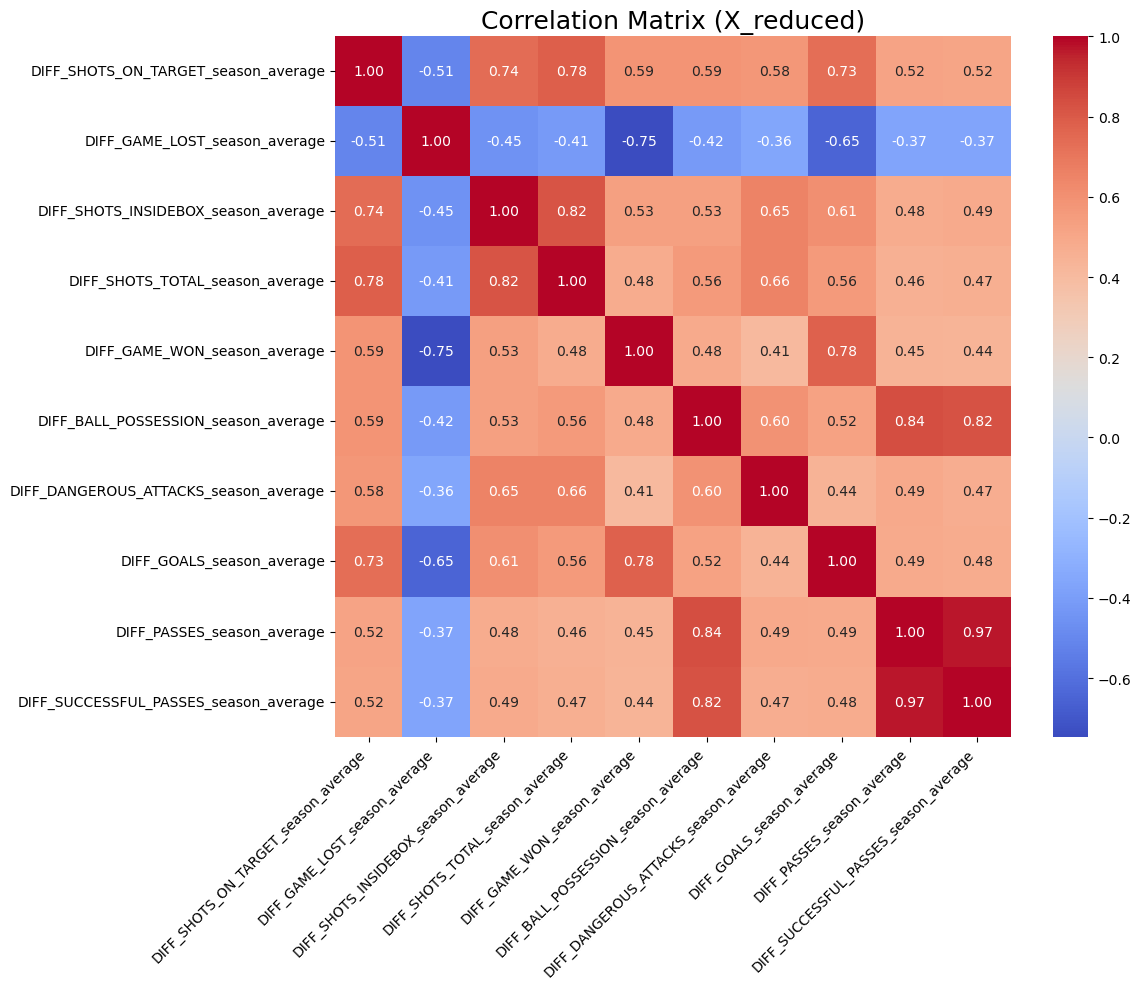

In [21]:
plot_correlation_matrix(X_reduced, title="Correlation Matrix (X_reduced)")

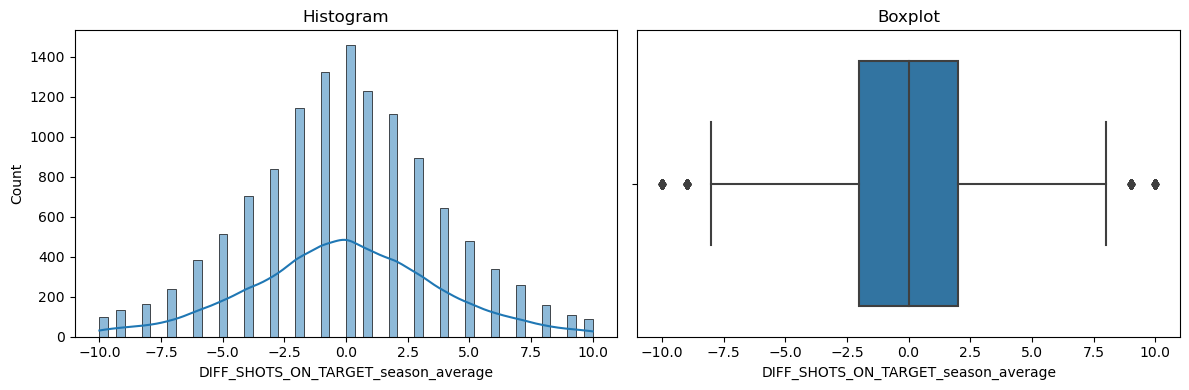

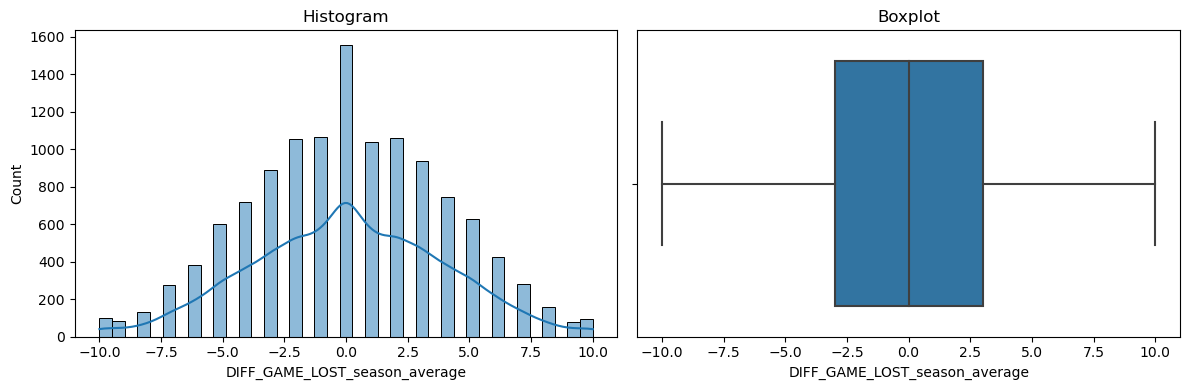

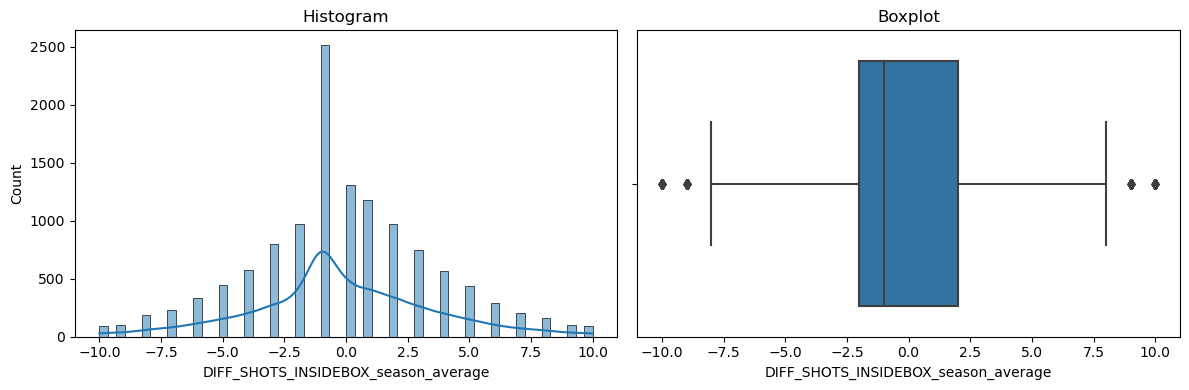

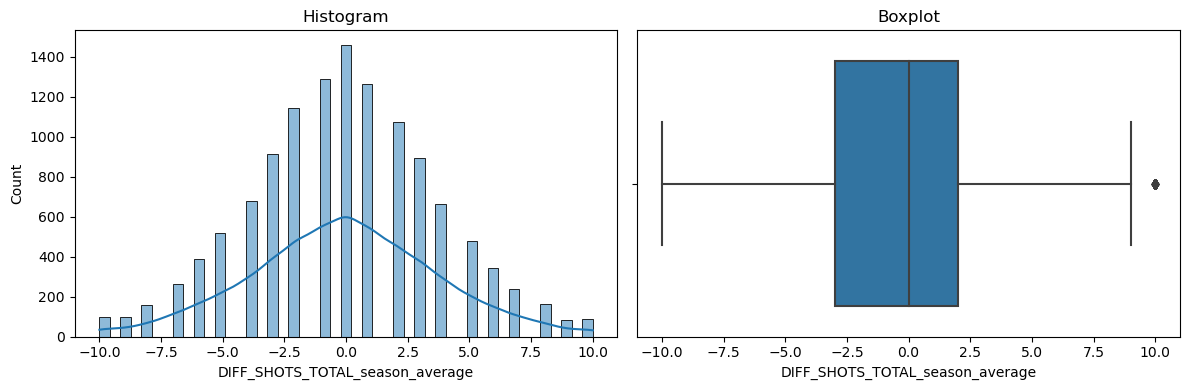

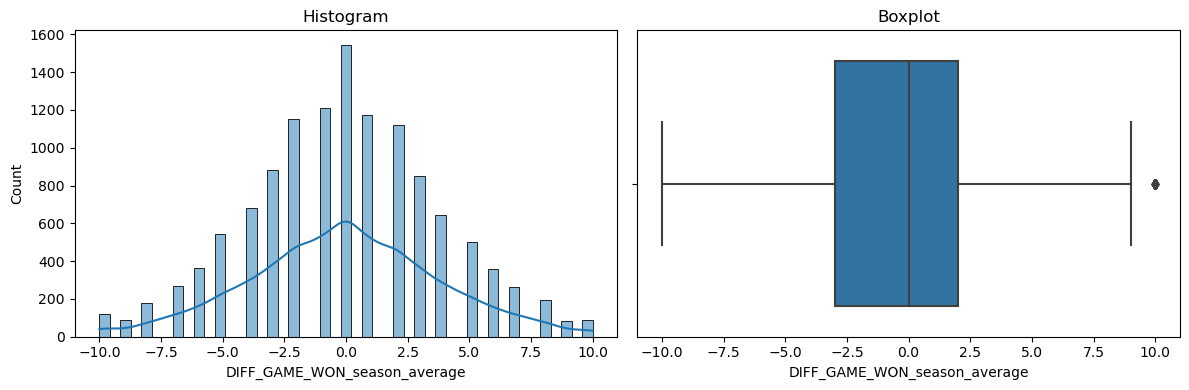

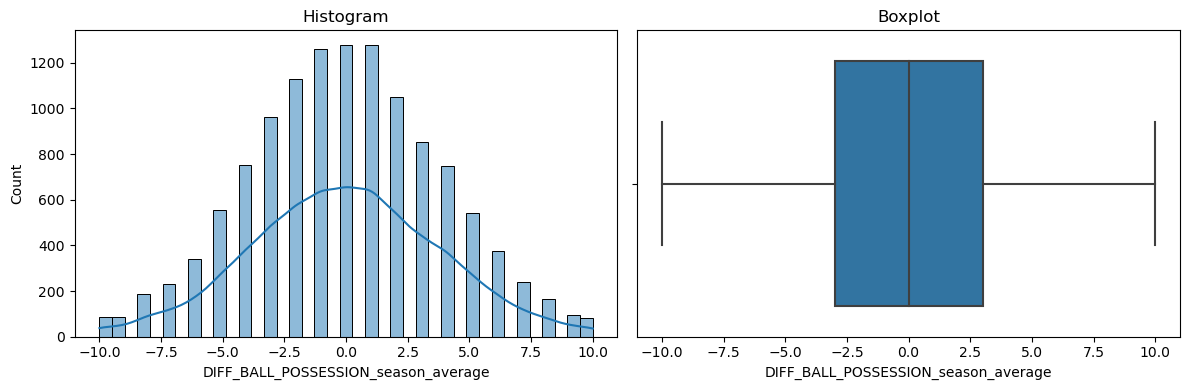

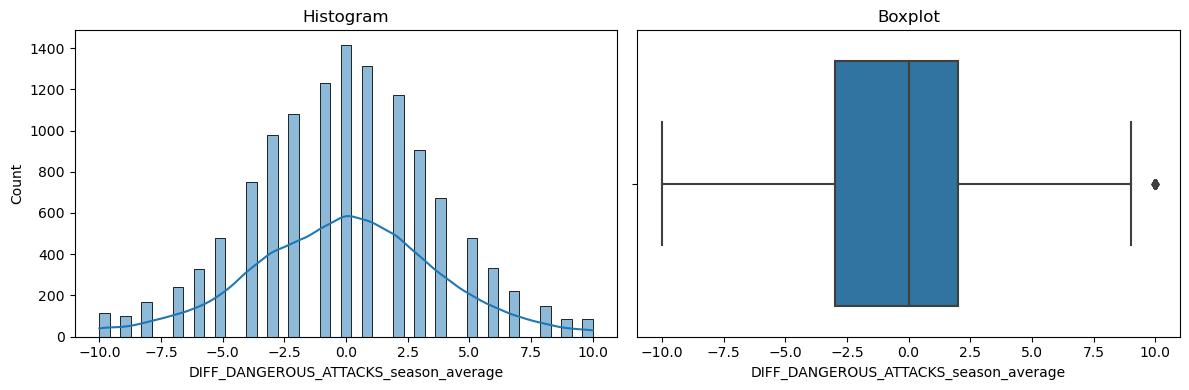

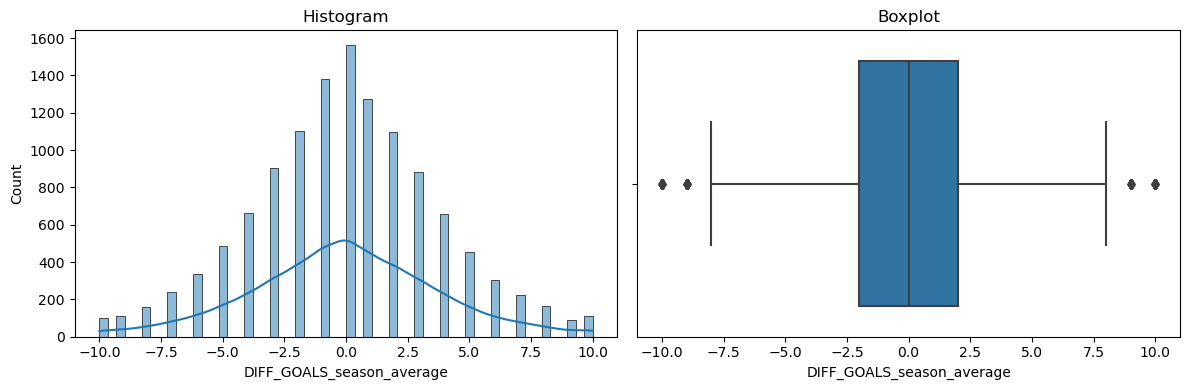

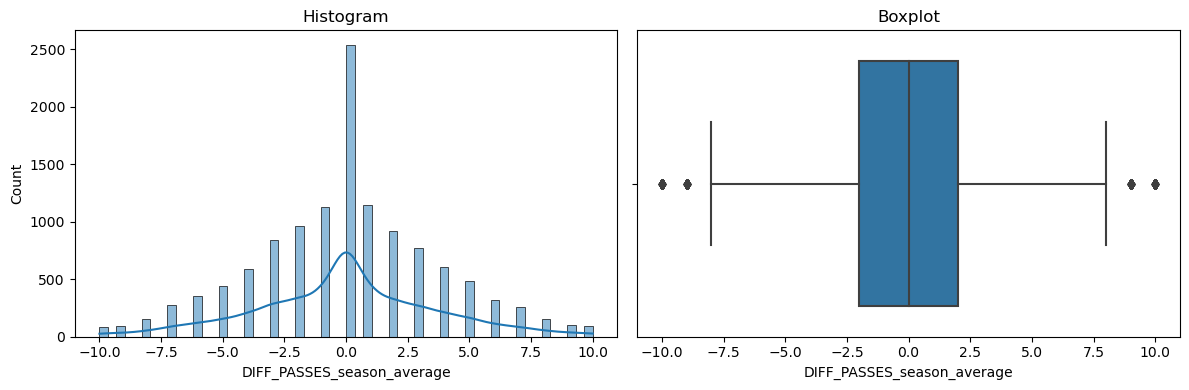

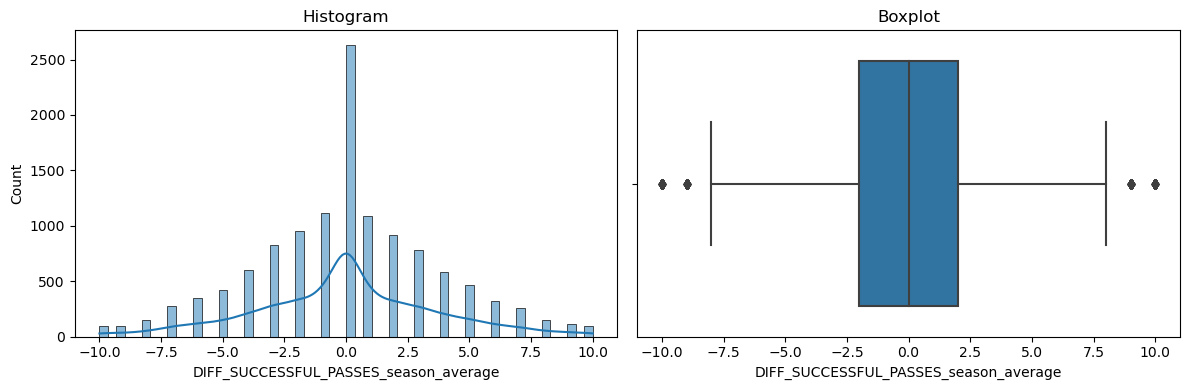

In [22]:
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
cat_cols = X_reduced.select_dtypes(include=["object", "category"]).columns
plot_univariate_analysis(X_reduced, numeric_cols=num_cols, categorical_cols=cat_cols)